<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/simpleRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.





In [55]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt


# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `phi1` und `phi2` die `x` und `y` Position berechnet werden kann. 

Der Einfachheit halber (um auszuschließen, dass gleiche Positionen mit unterschiedlichen Winkelstellungen angefahren werden können) wird `phi1` auf 0 .. 90 Grad und `phi2` auf -90 .. 90 Grad eingeschränkt.

## Vorab: Vektoren und Matrizen in numpy

In [10]:
a = np.array([1,2,3]) # Zeilenvektor a
b = np.array([4,5,6]) # Zeilenvektor b

M = np.vstack((a, b)) # Zusammenfassen als 2x3 Matrix

M = M.T # Transponieren -> 3x2 Matrix

print(a, b)
print(M)

sum_a_b = M.sum(axis=1) # Summe der Spaltenvektoren
print(sum_a_b)

[1 2 3] [4 5 6]
[[1 4]
 [2 5]
 [3 6]]
[5 7 9]


## OK, jetzt also die Trainingsdaten

In [91]:
l1 = 1  # Länge des ersten Roboterarms
l2 = 1  # Länge des zweiten Roboterarms


traindatasize = 200000 # Wie viele Traingsdaten sollen generiert werden?

# phi1 im Bereich von 0 .. 90 Grad 
phi1train = np.random.random_sample(traindatasize) * np.pi/2 

# phi2 im Bereich von 0 .. -90 Grad 
phi2train = -np.random.random_sample(traindatasize) * np.pi/2

# Kombiniere Vektoren als Matrix
dout = np.vstack((phi1train, phi2train)).T

# Berechne x und y
din = np.array([l1 * np.cos(dout[:,0]) + l2 * np.cos(dout.sum(axis=1)), 
                l1 * np.sin(dout[:,0]) + l2 * np.sin(dout.sum(axis=1))]).T 

print(dout[:4])
print(din[:4])




[[ 1.18585938 -1.48153393]
 [ 1.11847372 -1.13638772]
 [ 0.72282645 -0.18451364]
 [ 1.19231043 -1.0006454 ]]
[[1.3321065  0.63543692]
 [1.43689529 0.88152138]
 [1.60851391 1.17419512]
 [1.35120237 1.11971889]]


No handles with labels found to put in legend.


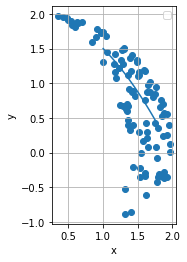

In [98]:
xt = np.linspace(1, 1.8)
yt = -0.5*xt*xt +2


def plot_range():
  plt.scatter(din[:100,0], din[:100,1])
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.grid(True)
  plt.gca().set_aspect("equal")

  plt.plot(xt, yt)

plot_range()

# Konstruiere NN

Zwei Fully Connected Layer, der erste Layer mit Aktivierungsfunktion.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Als Optimierungsfunktion stochastischer Gradientenabstieg.

In [64]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(100, input_shape=[2,], activation='tanh'),
      layers.Dense(100, activation='tanh'),
      layers.Dense(2)     ## output
  ])

  model.compile(loss='mean_squared_error',
                optimizer=optimizers.SGD(learning_rate=0.01))
  return model

In [92]:
mymodel = build_and_compile_model()
mymodel.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 202       
Total params: 10,602
Trainable params: 10,602
Non-trainable params: 0
_________________________________________________________________


## Welche Vorhersage liefert das untrainierte Modell?

In [40]:

predicted = mymodel.predict(din[:5])
print(predicted)
print(dout[:5])

[[-0.20692246 -0.43047446]
 [-0.27782518 -0.43620056]
 [-0.18686733 -0.35769653]
 [-0.24229693 -0.4443589 ]
 [-0.23147933 -0.16889742]]
[[ 0.3430418   0.8998665 ]
 [ 1.10182333  0.59959618]
 [ 1.41400316 -1.3849327 ]
 [ 1.42996553 -0.69131346]
 [ 0.10173351 -1.2245569 ]]


## Trainiere Modell

Nutze 20% der Testdaten als Validierungsdatensatz

In [93]:
history = mymodel.fit(din, dout,
          batch_size=32, epochs=10,
          validation_split = 0.2)

Epoch 1/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0906 - val_loss: 0.0227
Epoch 2/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0182 - val_loss: 0.0096
Epoch 3/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0089 - val_loss: 0.0078
Epoch 4/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 5/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 6/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 7/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 8/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 9/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 10/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.006

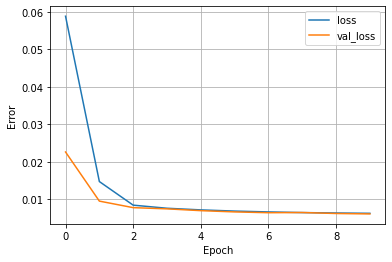

In [94]:


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [71]:
predictions = mymodel.predict(din)


for i in range(10):
  print(predictions[i], dout[i])

[ 1.002233   -0.70800805] [ 1.04365318 -0.80033387]
[ 1.4930332 -1.0836202] [ 1.52140946 -1.09208328]
[ 0.08824276 -0.79395926] [ 0.10460715 -0.80828792]
[ 0.9314869 -1.5085565] [ 0.87875538 -1.42543218]
[ 0.4996777 -1.0106618] [ 0.52356186 -1.07296112]
[ 1.123345  -0.3690948] [ 1.06156696 -0.26294894]
[ 1.4758186  -0.83249986] [ 1.52878743 -0.90085234]
[ 1.4251401 -0.25895  ] [ 1.41711518 -0.25810921]
[ 0.405667  -1.2314012] [ 0.4028859  -1.25412792]
[ 0.2089364 -1.3887409] [ 0.20934054 -1.39315595]


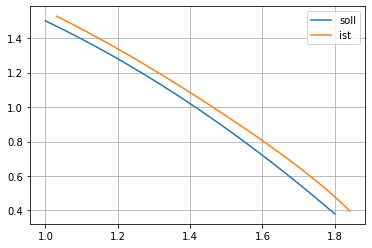

In [99]:
xtest = np.linspace(1.5,1.7)
ytest = 1/0.2*(xtest-1.5) -0.5

xtest = np.linspace(1, 1.8)
ytest = -0.5*xt*xt +2


def plot_trajectory():
  plt.plot(xtest,ytest, label='soll')
  phipred = mymodel.predict(np.vstack((xtest, ytest)).T)

  # Berechne x und y
  xpred = l1 * np.cos(phipred[:,0]) + l2 * np.cos(phipred.sum(axis=1))
  ypred = l1 * np.sin(phipred[:,0]) + l2 * np.sin(phipred.sum(axis=1))

  plt.plot(xpred, ypred, label='ist')
  plt.grid(True)
  plt.legend()


plot_trajectory()


